In [1]:

import os
import pandas as pd
import numpy as np
import seaborn  as sns
from plotnine import *
import random
import warnings

from IPython.display import Image

from functools import partial

from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox

from utilsforecast.evaluation import evaluate
from utilsforecast.feature_engineering import pipeline, trend
from utilsforecast.losses import rmse, mae, mape as _mape, mase, quantile_loss, mqloss

def mape(df, models, id_col = "unique_id", target_col = "y"):
    df_mape = _mape(df, models, id_col=id_col, target_col=target_col)
    df_mape.loc[:, df_mape.select_dtypes(include='number').columns] *= 100
    return df_mape

from statsforecast import StatsForecast
from statsforecast.models import SklearnModel
from statsforecast.utils import ConformalIntervals
from statsforecast.models import (
    WindowAverage,
    Naive,
    SeasonalNaive,
    RandomWalkWithDrift,
    HistoricAverage,
)

# change working directory 
# Check if current directory has any .ipynb files
if any(fname.endswith(".ipynb") for fname in os.listdir()):
    os.chdir("..")

# load local package modules
from gas_pump_prices.preprocess import * 

%load_ext autoreload
%autoreload 2

# Chapter 5: The forecaster's toolbox
## 5.2. Some simple forecasting methods 

In practice, simple methods are only useful a references. 

### Mean method 

Forecasts of all future values ($T + h$) are set to be the average of all previous values. 

$$
\hat{y}_{T+h|T} = \bar{y} = \frac{(y_1 + ... + y_T)}{T}
$$

### Naïve method

Each forecast is set to the previous value. 

$$
\hat{y}_{T+h|T} = y_T
$$

### Seasonal naïve method 

Each forecast is set to its value in the prior period of last season. For example, a prediction for a Monday on weekly data would be the value on the prior Monday. Mathematically, the value for the next prediction given all previous $T$ observations, $T + h|T$, is the value from the same $m$ season from the last period, which is defined as the number of complete seasons that have elapsed ($m(k+1)$, where the integer of $k=(k-1)/m$ and is taken). 

$$
\hat{y}_{T+h|T} = y_{T+h - m(k+1)}
$$

### Drift method

Forecasts are set to the average change observed over the entire course of the time series. 

$$
\hat{y}_{T+h|T}  = y_{T+h} + h \Big(\frac{y_t - y_1}{T -1}\Big)
$$

/var/folders/89/k8gtyblx5nj1gsmlk919bct80000gn/T/ipykernel_16196/511585597.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


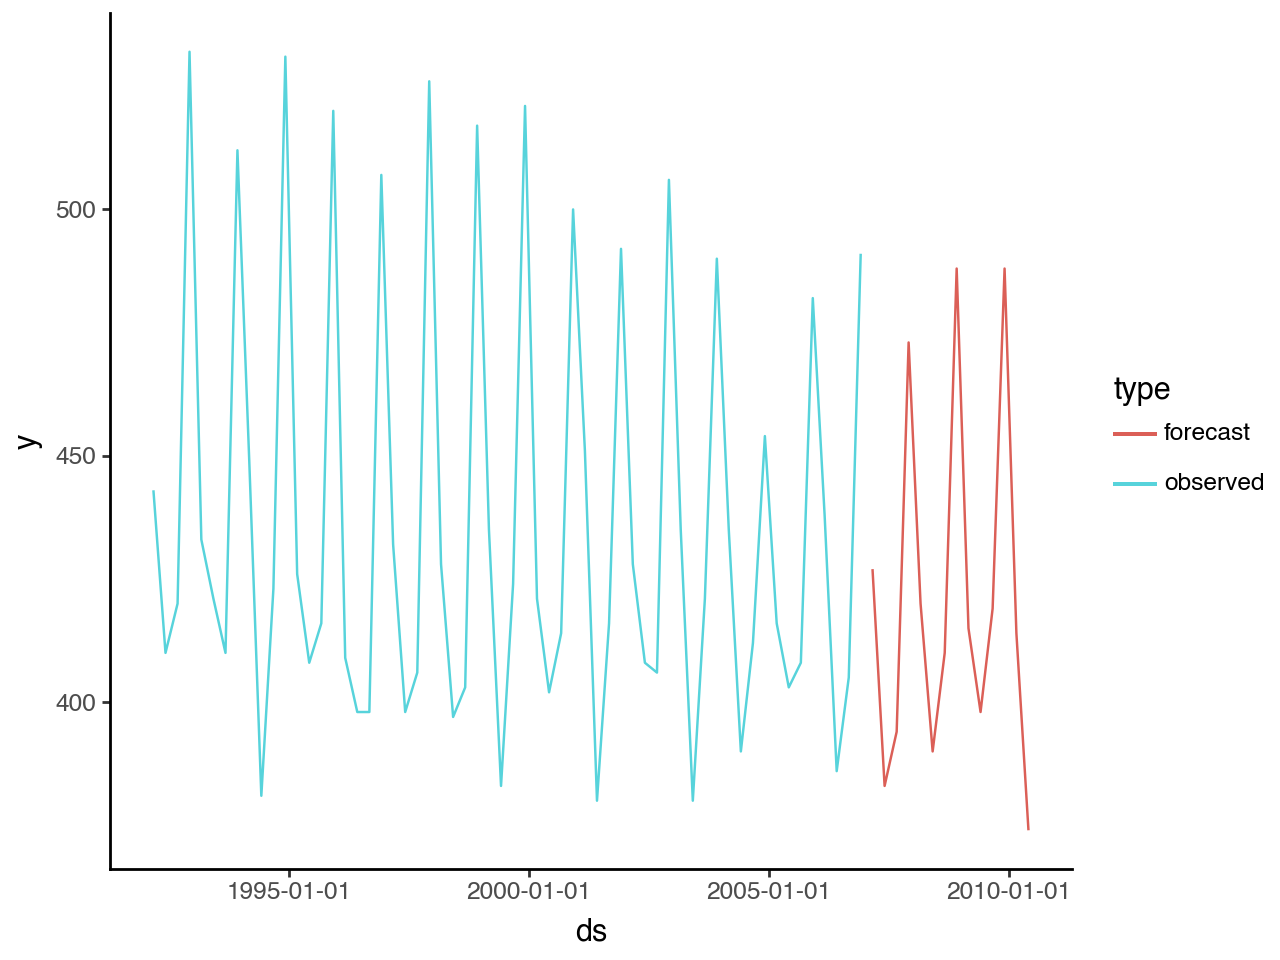

In [25]:
df_aus_beer = pd.read_csv('data/raw/aus_production_formatted.csv')

beers_df = df_aus_beer.query("unique_id == 'Beer' and ds >= '1992-01-01'")
df_train = beers_df[:-14]
df_test = beers_df[-14:]

avg_method = HistoricAverage()
naive_method = Naive()
seasonal_naive_method = SeasonalNaive(4)

sf = StatsForecast(
    models=[avg_method, naive_method, seasonal_naive_method], 
    freq=pd.offsets.QuarterBegin(1)
)
sf.fit(df_train)

df_forecast = sf.predict(h=14)
df_forecast["y"] = df_test["y"].values

df_train['type'] = 'observed'
df_forecast['type'] = 'forecast'

df_merged = pd.concat(objs=[df_train, df_forecast], ignore_index=True)
df_merged['ds'] = pd.to_datetime(df_merged['ds'])

(ggplot(data=df_merged, mapping=aes(x='ds', y='y', group='type', color='type')) + 
 geom_line() + 
 theme_classic())

In [26]:
df_forecast

,unique_id,ds,HistoricAverage,Naive,SeasonalNaive,y,type
0,Beer,2007-03-01,436.45,491.0,438.0,427.0,forecast
1,Beer,2007-06-01,436.45,491.0,386.0,383.0,forecast
2,Beer,2007-09-01,436.45,491.0,405.0,394.0,forecast
3,Beer,2007-12-01,436.45,491.0,491.0,473.0,forecast
4,Beer,2008-03-01,436.45,491.0,438.0,420.0,forecast
5,Beer,2008-06-01,436.45,491.0,386.0,390.0,forecast
6,Beer,2008-09-01,436.45,491.0,405.0,410.0,forecast
7,Beer,2008-12-01,436.45,491.0,491.0,488.0,forecast
8,Beer,2009-03-01,436.45,491.0,438.0,415.0,forecast
9,Beer,2009-06-01,436.45,491.0,386.0,398.0,forecast


## 5.6. Forecasting using transformations 

When back-transforming to the original scale, both the point forecast and the prediction interval can be biased. As an example, consider the Box-Cox transformation. When back-transformed, the point forecast will not be the mean distribution. Although not always a problem, this can be an issue when adding sales forecasts from various regions. 

For Box-Cox transformations, the back-transformed mean is approximated by 

$$
\hat{y}_{T+h|T} = 
\begin{cases}
\exp(\hat{w}_{T_h|T})\Big[1 + \frac{\sigma^2_h}{2}\Big]  \text{if } \lambda = 0 \\
(\lambda \hat{w}_{T+h|T} + 1)^(\frac{1}{\lambda})  \big[\lambda \hat{w}_{T+h|T}  +1)^2 \big], 
\end{cases}
$$

where $\hat{w}_{T+h|T}$ is the $h$-step forecast mean and $\sigma^2_h$ is the h-step forecast variance on the transformed scale. The biased calculation for the back-transformed mean is provided by 

$$
y_t = 
\begin{cases}
\exp (w_t) \text{ if }\lambda=0 \\ 
sign (\lambda w_t + 1) |\lambda w_t + 1 |^{\frac{1}{\lambda}}
\end{cases}
$$

In [35]:
fcasts_original.head()

,unique_id,ds,RWD,RWD-lo-80,RWD-lo-95,RWD-hi-80,RWD-hi-95,RWD-adjusted
0,eggs,1993-12-31,61.279118,51.664289,47.201153,72.683286,79.555901,61.823857
1,eggs,1994-12-31,60.304003,47.311382,41.608356,76.864650,87.400060,61.387551
2,eggs,1995-12-31,59.344406,44.018784,37.580011,80.005811,93.713609,60.960701
3,eggs,1996-12-31,58.400078,41.287853,34.364037,82.604659,99.248206,60.542936
4,eggs,1997-12-31,57.470776,38.923818,31.668655,84.855245,104.295245,60.133901


/opt/anaconda3/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/anaconda3/lib/python3.12/site-packages/utilsforecast/processing.py:440: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.


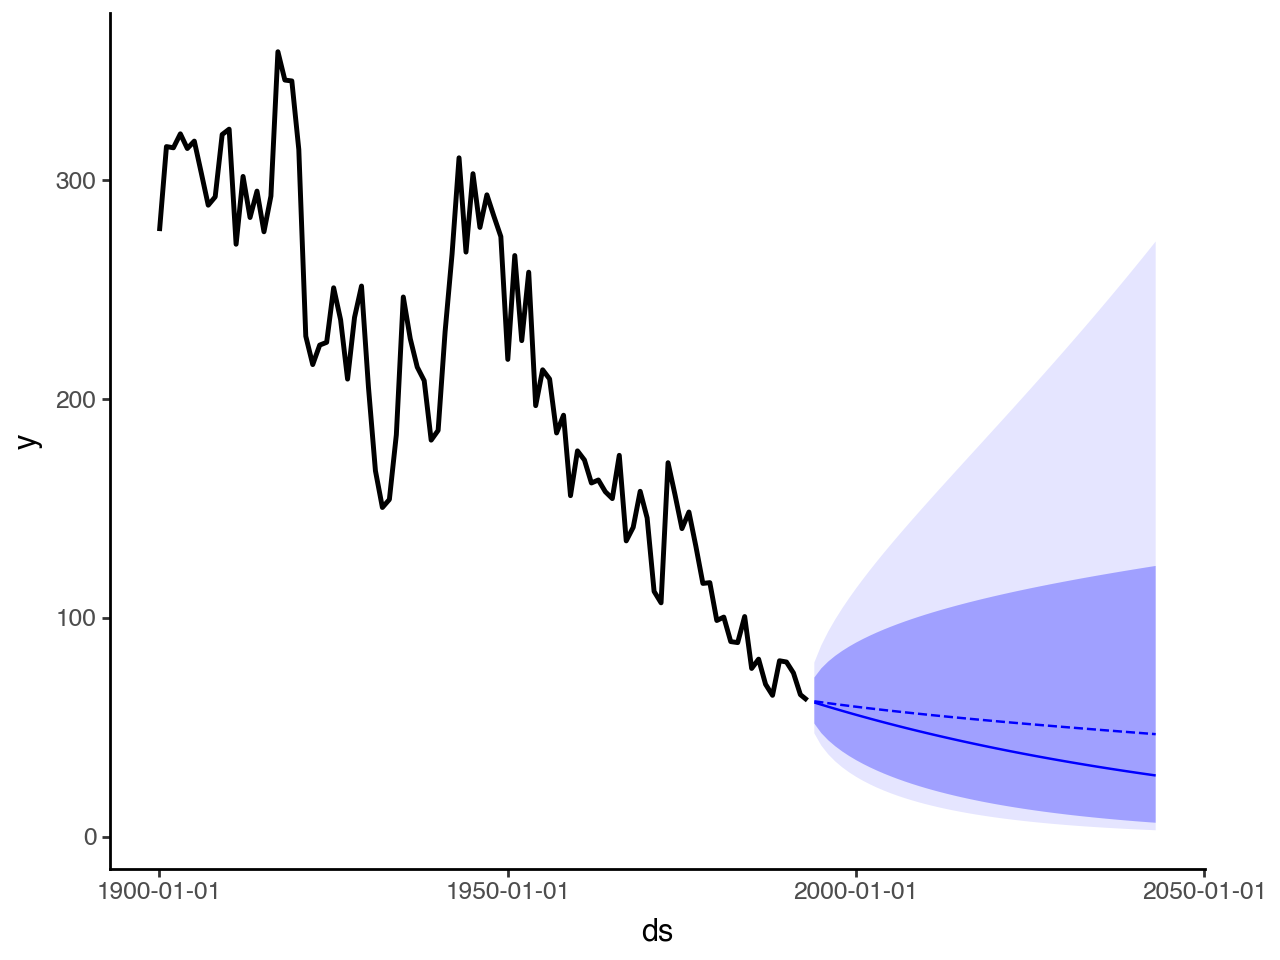

In [45]:
df_egg = pd.read_csv("data/raw/eggs.csv", parse_dates=["ds"])
df_egg_log = df_egg.copy()
df_egg_log['y'] = np.log(df_egg_log['y'])

rwd_method = RandomWalkWithDrift()
sf = StatsForecast(models=[rwd_method], freq="Y")
sf.fit(egg_df_log)
fcasts = sf.forecast(df=egg_df_log, h=50, level=[80, 95])
sigma_h = (fcasts['RWD-hi-80'] - fcasts['RWD-lo-80']) / (2 * 1.28)
sigma_h_squared = sigma_h**2
bias_adjusted = np.exp(fcasts['RWD']) * (1 + sigma_h_squared/2)
fcasts_original = fcasts.copy()
columns_to_transform = \
  ['RWD', 'RWD-lo-80', 'RWD-lo-95', 'RWD-hi-80', 'RWD-hi-95']
for col in columns_to_transform:
    fcasts_original[col] = np.exp(fcasts[col])
fcasts_original['RWD-adjusted'] = bias_adjusted

# filter on dates greater than last observed date
date_last_obs = df_egg['ds'].max()
df_fcast_new = fcasts_original.loc[fcasts_original['ds'].ge(date_last_obs)]

(ggplot(data=df_egg, mapping=aes(x='ds', y='y')) + 
  geom_line(size=1) + 
  geom_line(inherit_aes=False, data=fcasts_original, 
           mapping=(aes(x='ds', y='RWD')), color='blue') + 
  geom_line(inherit_aes=False, data=fcasts_original, 
           mapping=(aes(x='ds', y='RWD-adjusted')), color='blue', linetype='dashed') + 
  geom_ribbon(inherit_aes=False, data=df_fcast_new, 
              mapping=aes(ymin='RWD-lo-95', ymax='RWD-hi-95', x='ds'), alpha=.1, fill='blue') + 
  geom_ribbon(inherit_aes=False, data=df_fcast_new, 
              mapping=aes(ymin='RWD-lo-80', ymax='RWD-hi-80', x='ds'), alpha=.3, fill='blue') +
  theme_classic())

## 5.7. Forecasting with decomposition 

Using an additive decomposition, each score can be decomposed into the sum of a seasonal component ($\hat{S}_t$) and a seasonal-adjusted component ($\hat{A}_t = \hat{T}_t + \hat{R}_t$). Each component is estimated separately and $S_t$ is assumed to be unchanging or changing very slowly. To this point, $S_t$ is often estimated using simple methods such as taking the previous occurrence of the value (i.e., seasonal naïve method). 

Any non-seasonal forecasting method can be used to estimate the seasonally-adjusted component ($\hat{A}_t$; e.g., drift method, Holt's method, non-seasonal ARIMA model). 

## 5.8. Evaluating point forecast accuracy 



Keep a hold-out set of data to obtain an accurate estimate of forecasting performance. The test data should contain at least as many time points (in the future) as the forecasting horizon.

Forecast errors represent residuals on future data (i.e., on the test set) and differ from residuals in that they can be based on multi-step forecasts (h>1; residuals are always based on one-step forecasts).

$$
\epsilon_{T+h} = y_{T+h} - \hat{y}_{T+h|T}
$$

Three general categories of forecasting errors:

1. **Scale-dependent errors**: errors are on same scale as data. Useful by itself, but not possible to make predictions with models using different scales. Two common examples:

$$ 
\text{Mean absolute error: MAE} = mean(|\epsilon_t|) \\ 
\text{Root mean squared error: RMSE} = \sqrt{mean(\epsilon^2_t)}
$$

As an aside, minimizing the MAE leads to forecasts of the median and minimizing the RMSE leads to forecasts of the mean.

2. **Percentage error**: unit-free ($p_t = 100 \frac{e_t}{y_t}$), but can become infinite and undefined. Moreover, extreme values occur when the observed value is close to 0. Related to this, percentage errors assume a meaningful zero, which is not always the case (e.g., temperature). Although sMAPE was created to address shortcomings of percentage errors, authors recommend not using because even this is severely limited.

3. **Scaled errors**: proposed by Hyndman & Koehler (2006) and likely the best option when comparing time series models across different units because the errors are scaled by the training MAE. For non-seasonal time series, this entails using a naïve forecast as a reference: 

$$
q_j = \frac{\epsilon_j}{\frac{1}{T-1} \sum^T_{t=2}|y_t - y_{t-1}}, 
$$

with the mean absolute error simply being 

$$
\text{MASE} = mean(|q_j|)
$$.

/opt/miniconda3/lib/python3.13/site-packages/utilsforecast/processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
/opt/miniconda3/lib/python3.13/site-packages/utilsforecast/processing.py:440: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
/var/folders/yc/2l2dbqc565l5ryrcfz4x3w680000gn/T/ipykernel_39428/2935241781.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


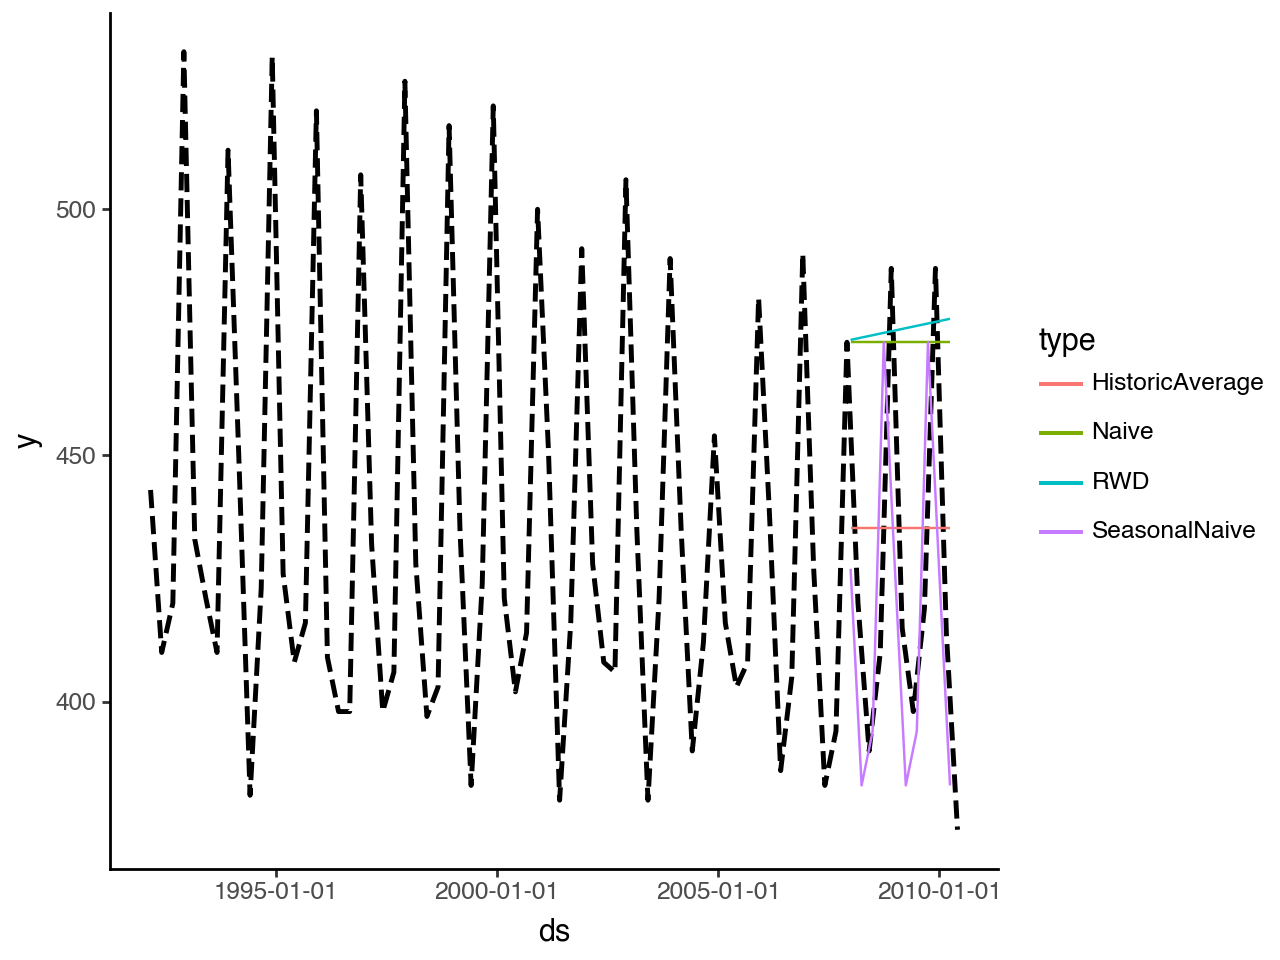

In [44]:
# Example using differnt types of error measurements for quarterly beer production 
df_aus_beer = pd.read_csv('data/raw/aus_production_formatted.csv', parse_dates=['ds'])

df_aus_beer = df_aus_beer.query("unique_id == 'Beer' and ds >= '1992-01-01'")

df_train = df_aus_beer.query("ds.dt.year <= 2007")
df_test = df_aus_beer.query("ds.dt.year > 2007")

mean_method = HistoricAverage()
naive_method = Naive()
drift_method = RandomWalkWithDrift()
seasonal_naive = SeasonalNaive(4)

sf = StatsForecast(
    models=[drift_method, mean_method, naive_method, seasonal_naive],
    freq="Q")

# make forecasts 10 steps into future
df_forecasts = sf.forecast(df=df_train, h=10)

# convert to long format + add in actual values for prediction period 
df_long = df_forecasts.melt(id_vars=['unique_id', 'ds'], var_name='type', value_name='y' )
df_train['type'] = 'observed'

(ggplot(data=df_aus_beer, mapping=aes(x='ds', y='y')) +
    geom_line(size=1, color='black', linetype='dashed') + 
    geom_line(inherit_aes=False, data=df_long, 
                mapping=aes(x='ds', y='y', group='type', color='type')) + 
    theme_classic())

In [39]:
df_aus_beer = df_aus_beer.assign(
    ds = df_aus_beer['ds'] + pd.offsets.MonthEnd(0))

# merge in y values 
# df_forecasts = df_forecasts.merge(right=df_aus_beer, on=['unique_id', 'ds'])

evaluation = evaluate(df_forecasts, metrics=[rmse, mae, mape,
  partial(mase, seasonality=4)], train_df=df_train)
evaluation.T

,0,1,2,3
unique_id,Beer,Beer,Beer,Beer
metric,rmse,mae,mape,mase
RWD,56.367685,48.785714,11.875124,3.411588
HistoricAverage,35.257136,32.45,7.437802,2.269231
Naive,54.316664,47.5,11.537365,3.321678
SeasonalNaive,44.529765,39.3,8.90178,2.748252


In [40]:
train_df = df_aus_beer.query("ds.dt.year <= 2007")
test_df = df_aus_beer.query("ds.dt.year > 2007")

mean_method = HistoricAverage()
naive_method = Naive()
drift_method = RandomWalkWithDrift()
seasonal_naive = SeasonalNaive(4)

sf = StatsForecast(
    models=[drift_method, mean_method, naive_method, seasonal_naive],
    freq="Q"
)
preds = sf.forecast(df=train_df, h=10)
preds = preds.merge(right=df_aus_beer, on=['unique_id', 'ds'])

evaluation = evaluate(preds, metrics=[rmse, mae, mape,
  partial(mase, seasonality=4)], train_df=train_df)

evaluation

/opt/miniconda3/lib/python3.13/site-packages/utilsforecast/processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
/opt/miniconda3/lib/python3.13/site-packages/utilsforecast/processing.py:440: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.


,unique_id,metric,RWD,HistoricAverage,Naive,SeasonalNaive
0,Beer,rmse,64.901293,38.447245,62.692902,14.310835
1,Beer,mae,58.876190,34.825000,57.400000,13.400000
2,Beer,mape,14.577487,8.283390,14.184424,3.168503
3,Beer,mase,4.117216,2.435315,4.013986,0.937063


In [8]:
df_aus_beer.assign(
    ds = df_aus_beer['ds'] + pd.offsets.MonthEnd(0)).tail()

,unique_id,ds,y
213,Beer,2009-06-30,398.0
214,Beer,2009-09-30,419.0
215,Beer,2009-12-31,488.0
216,Beer,2010-03-31,414.0
217,Beer,2010-06-30,374.0
